In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import time
from itertools import product, groupby
import math
import scipy.stats as stats

In [2]:
from mpmath import mp
mp.dps = 50

In [3]:
def prior_kernel(s,t):
    return np.exp(-((t-s)/5)**2)+0.0001*(s==t)

def runs(a_list):
    runs_zeros = len([k for k, g in groupby(a_list) if k == 0])
    runs_ones = len([k for k, g in groupby(a_list) if k == 1])
    return runs_ones + runs_zeros

def tr(actions):
    if len(actions)<100:
        return 1
    else:
        return 1-0.02*(100-sum(actions[-100:-1]))/100

In [4]:
class posterior:
    def __init__(self, T, T0, x, y, K,sigma):
        self.T = T
        self.x = x
        self.y = y
        self.n = y.shape[0]
        self.g = T.shape[0]
        self.T0 = np.array(T0)
        self.sigma = sigma
        self.K = K
        self.K0 = self.get_K0()

    def get_K(self):
        return self.K

    def getter(self):
        return self.K0

    def get_K0(self):
        tau = np.where(self.T0==1)[0]
        K_tau=self.K[:, tau]
        K_tau_tau = self.K[tau[:, None], tau]
        return self.K- np.dot(np.dot(K_tau, np.linalg.inv(K_tau_tau)), K_tau.T)

    def Lx0(self,t):
        L = np.zeros(self.n)
        for i in np.arange(0,self.n):
            L[i] = np.trapz(self.K0[t, :] * self.x[i,:], self.T)
        return L

    def likelihood(self): #p(Y|T0)
        m_matrix = self.M()
        first = np.linalg.det(m_matrix) ** (-0.5)


        inv = np.linalg.inv(m_matrix)
        s11 = np.dot(np.dot(np.transpose(np.ones(self.n)),inv),np.ones(self.n))

        syy = np.dot(np.dot(np.transpose(self.y),inv),self.y)
        s1y = np.dot(np.dot(np.transpose(np.ones(self.n)),inv),self.y)
        b = 0.5*(syy-s1y**2/s11)

        return first/np.sqrt(s11)*(b**(-0.5*(self.n-1)))

    def R0(self,i, j):
        Ri = np.trapz(self.K0[:, :] * self.x[i, :], self.T, axis=1)
        Rij = np.trapz(Ri * self.x[j, :],self.T)
        return Rij

    def M(self):
        return np.array([[self.R0(i, j) for j in range(self.n)] for i in range(self.n)])+np.identity(self.n)

    def posterior_mean_cov(self):
        M_mat = self.M()
        inv = np.linalg.inv(M_mat)
        S11 = np.dot(np.dot(np.transpose(np.ones(M_mat.shape[0])),inv),np.ones(M_mat.shape[0]))
        SY1 = np.dot(np.dot(np.transpose(self.y),inv),np.ones(M_mat.shape[0]))

        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx0(t)), inv), (self.y - (SY1 / S11) * np.ones(len(self.y))))
            return mean
        def Kstar(s,t):
            cov = (self.sigma**2)*(self.K0[s,t] - np.dot(np.dot(np.transpose(self.Lx0(s)),inv),self.Lx0(t)))
            return cov

        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        C = np.fromfunction(np.vectorize(lambda t, s: Kstar(s,t)), (self.g,self.g), dtype=int)
        return m,C

    def only_mean(self):
        inv = np.linalg.inv(self.M())
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx0(t)),inv),self.y)
            return mean
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        return m

    def fitted_values(self):
        m = self.only_mean()
        return np.fromfunction(np.vectorize(lambda i: np.trapz(self.x[i,:]*m,self.T)), (self.n,), dtype=int)

In [5]:
class T0_est:
    def __init__(self, T, x, y,K,sigma,alpha,n_sim=1000,burn=0):
        self.T= T
        self.x=x
        self.y=y
        self.sigma=sigma
        self.alpha=alpha
        self.n_sim=n_sim
        self.burn=burn
        self.n = y.shape[0]
        self.g = T.shape[0]
        self.K=K
        self.count = 0

        self.T0_init = np.array([0, 1] * (self.g // 2))
        self.action = []

    def chain_builder(self):
        chain = [self.T0_init]
        for i in range(self.n_sim):
            curr=chain[-1]
            chain.append(self.next_T0(curr))
            print('Current Number of Points in T0: '+str(sum(chain[-1])))
        return chain[self.burn:]


    def next_T0(self,current):
        new = self.candidate(current)
        rate=self.acceptance_rate(current,new)
        print('Acceptance Rate = '+str(rate)+'\n')
        treshold = tr(self.action)

        self.count = self.count + 1
        print(str(self.count)+'/'+str(self.n_sim) + ' in findind T0...\n')
        if rate>=treshold:
            self.action.append(1)
            return new

        else:
            self.action.append(0)
            return current

    def candidate(self,old):
        new=old.copy()
        coin = np.random.uniform(0,1,1)

        if coin<0.2: #split
            choices = [i for i in range(1,len(old) - 1) if old[i-1] == 1 and old[i] == 1 and old[i + 1] == 1]
            if len(choices)>0:
                choice = np.random.choice(choices)
                splitting_point = choice
                new[splitting_point]=0

        if (coin>=0.2) and (coin<0.4): #right removal
            choices = [i for i in range(0,len(old)-1) if old[i] == 1 and old[i + 1] == 0]
            if len(choices)>0:
                choice = np.random.choice(choices)
                removing_point = choice
                new[removing_point]=0

        if (coin>=0.4) and (coin<0.6): #left removal
            choices = [i+1 for i in range(0,len(old)-1) if old[i] == 0 and old[i + 1] == 1]
            if len(choices)>0:
                choice = np.random.choice(choices)
                removing_point = choice
                new[removing_point]=0

        if (coin>=0.6) and (coin<0.8): #right add
            choices = [i for i in range(1,len(old)) if old[i-1] == 1 and old[i] == 0]
            if len(choices)>0:
                choice = np.random.choice(choices)
                adding_point = choice
                new[adding_point]=1

        if coin>=0.8: #left add
            choices = [i for i in range(0,len(old)-1) if old[i] == 0 and old[i + 1] == 1]
            if len(choices)>0:
                choice = np.random.choice(choices)
                adding_point = choice
                new[adding_point]=1

        if sum(old)==0:
            choice = np.random.choice(range(len(old)))
            new[choice]=1
        return new


    def acceptance_rate(self,current,new):
        prior = self.PT0(current)
        prior_new = self.PT0(new)
        likl = posterior(self.T,current,self.x,self.y,self.K,self.sigma).likelihood()
        likl_new =posterior(self.T,new,self.x,self.y,self.K,self.sigma).likelihood()
        return (likl_new*prior_new)/(likl*prior)


    def PT0(self,current):
        r=runs(current)
        return mp.exp(-r*self.alpha)

In [6]:
sigma = 10
T = np.linspace(1, 288, 288)
K = np.fromfunction(np.vectorize(lambda s, t: prior_kernel(T[s], T[t])), (T.shape[0], T.shape[0]), dtype=int)

In [7]:
df = pd.read_csv('/kaggle/input/average-curves/average_curves.csv', index_col='idx')
df

,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
idx,,,,,,,,,,,,,,,,,,,,,
pat_number,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,150.000000,151.000000,152.000000,153.000000,154.000000,155.000000,156.000000,157.000000,158.000000,159.000000
severity,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
constancy,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
age,58.000000,59.000000,62.000000,65.000000,65.000000,70.000000,66.000000,74.000000,58.000000,74.000000,...,68.000000,49.000000,51.000000,66.000000,45.000000,74.000000,67.000000,59.000000,34.000000,72.000000
gender,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,-0.981659,-1.076615,-1.332550,-1.058805,-0.923807,-1.109480,-1.743754,-1.184359,-1.359995,-1.107242,...,-1.485589,-1.074087,-1.003103,-0.996204,-1.740179,-1.447827,-1.043098,-1.684661,-1.077221,-1.393487
284,-0.993531,-1.078280,-1.332549,-1.044116,-0.923762,-1.109441,-1.743714,-1.217882,-1.360021,-1.116414,...,-1.486356,-1.074077,-1.002612,-0.994606,-1.740226,-1.445859,-1.042748,-1.684662,-1.077203,-1.393533
285,-0.997926,-1.079618,-1.332558,-1.019142,-0.923818,-1.109399,-1.743523,-1.224489,-1.360155,-1.127783,...,-1.487368,-1.074091,-1.003404,-0.994287,-1.740254,-1.440550,-1.042608,-1.684662,-1.077191,-1.393537


In [8]:
idxs = np.random.permutation(range(159))[:]
x = df.iloc[7:, idxs].T.to_numpy()
y = df.iloc[1, idxs].T.to_numpy()

y23 = np.copy(y)
y23[y == 1] = 0
y23[y == 2] = 1
y23[y == 3] = 1
np.unique(y23)

array([0., 1.])

In [9]:
chain = T0_est(T, x, y23, K, sigma, 5, 500, 1).chain_builder()

Acceptance Rate = 21905.340353873558072883548855216719856734453549125

1/500 in findind T0...

Current Number of Points in T0: 145
Acceptance Rate = 22146.486697929528300336737731912132809139769684424

2/500 in findind T0...

Current Number of Points in T0: 146
Acceptance Rate = 22084.37876312315715626429573822339187181955509194

3/500 in findind T0...

Current Number of Points in T0: 147
Acceptance Rate = 0.000045153006478236685733729625466899196971476813879346

4/500 in findind T0...

Current Number of Points in T0: 147
Acceptance Rate = 0.000045153006478236685733729625466899196971476813879346

5/500 in findind T0...

Current Number of Points in T0: 147
Acceptance Rate = 22025.428005710701871847421708972004512664452768146

6/500 in findind T0...

Current Number of Points in T0: 148
Acceptance Rate = 22333.526813038725534575485335469314236517980274057

7/500 in findind T0...

Current Number of Points in T0: 147
Acceptance Rate = 22764.530088053974418284694766985062909931640787804

8/5

In [10]:
T0_hat, counts = stats.mode(chain[1:], axis=0)

In [11]:
result_df = pd.DataFrame({
    'T0_hat':T0_hat.flatten(),
    'counts':counts.flatten()
})

# Save the DataFrame to a CSV file
result_df.to_csv('/kaggle/working/outputT0.csv', index=False)

In [12]:
#T0_hat

In [13]:
fitted = posterior(T,T0_hat[0],x,y23,K,sigma).fitted_values()
logit_fitted = scipy.special.expit(fitted)

labels = np.zeros(len(logit_fitted))
ones= np.where(logit_fitted > 0.5)
labels[ones] = np.ones(len(ones))
acc=sum(labels==y23)/len(labels)


In [14]:
acc=pd.DataFrame({
    'acc':acc.flatten()
})
acc.to_csv('/kaggle/working/output_acc.csv', index=False)

In [15]:
print('Accuracy: '+str(sum(labels==y23)/len(labels)))

Accuracy: 0.6226415094339622


In [16]:
m,cov = posterior(T,T0_hat[0],x,y23,K,sigma).posterior_mean_cov()


In [17]:
# Save the DataFrame to a CSV file
result_dfm = pd.DataFrame({
    'm':m.flatten()
})
result_dfm.to_csv('/kaggle/working/output_m.csv', index=False)
result_dfc = pd.DataFrame({
    'cov':cov.flatten()
})
result_dfc.to_csv('/kaggle/working/output_cov.csv', index=False)

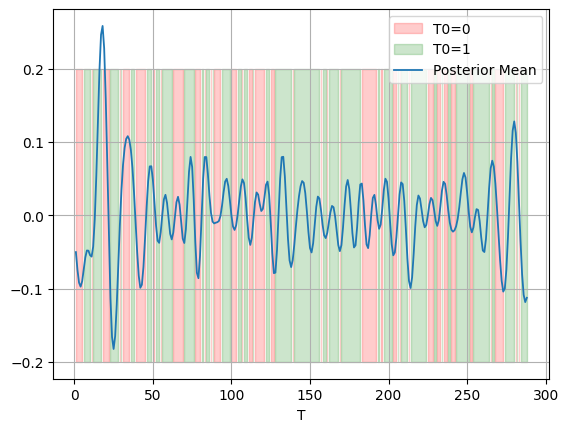

In [18]:
#plots
for i, color in enumerate(['red', 'green']):
    lab = 'T0='+str(i)
    plt.fill_between(T, -0.2, 0.2, where=(T0_hat == i), color=color, alpha=0.2, label=lab)

plt.plot(T,m,label='Posterior Mean',linewidth=1.3)
plt.xlabel('T')
plt.legend()
plt.grid(True)
plt.show()

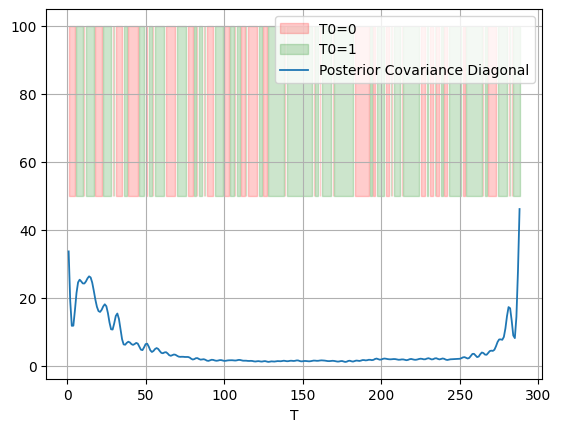

In [19]:
for i, color in enumerate(['red', 'green']):
    lab = 'T0='+str(i)
    plt.fill_between(T, 50, 100, where=(T0_hat == i), color=color, alpha=0.2, label=lab)

plt.plot(T,np.diag(cov),label='Posterior Covariance Diagonal',linewidth=1.3)
plt.xlabel('T')
plt.legend()
plt.grid(True)
plt.show()

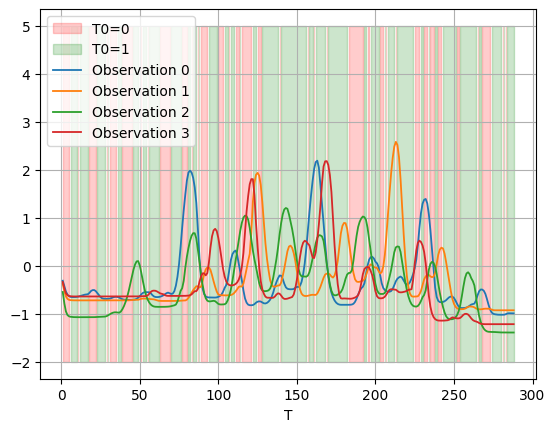

In [20]:
for i, color in enumerate(['red', 'green']):
    lab = 'T0='+str(i)
    plt.fill_between(T, -2, 5, where=(T0_hat == i), color=color, alpha=0.2, label=lab)

plt.plot(T,x[0,:],label='Observation 0',linewidth=1.3)
plt.plot(T,x[1,:],label='Observation 1',linewidth=1.3)
plt.plot(T,x[2,:],label='Observation 2',linewidth=1.3)
plt.plot(T,x[3,:],label='Observation 3',linewidth=1.3)
plt.xlabel('T')
plt.legend()
plt.grid(True)
plt.show()